# Notebook for model development
This notebook should be used to develop the model submodules locally. Note, that model relevant changes have to be made in the model subclasses. Additional code in this document is only used to get a better understanding of the dataflow and debug some outputs.

## 1: Set up environment
### Install dependencies
This will use the automation `install_dependencies.sh` in order to install necessary packages. Additional packages for development can be installed afterwards.

In [ ]:
! cd .. && bash automation/train_model/install_dependencies.sh

### Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 2: Get the data ready
In this step, the data will be imported and preprocessed.

### Download Dataset
The dataset has to be imported using the submodule `model/import_data.py`.

In [2]:
from model.import_dataset import import_dataset

images, labels, width, heigth = import_dataset("ea93eb20-616c-4ad2-9d82-cca701766612")

### Inspect dataset

Number of position training images:  10
Label von  4  bis  55


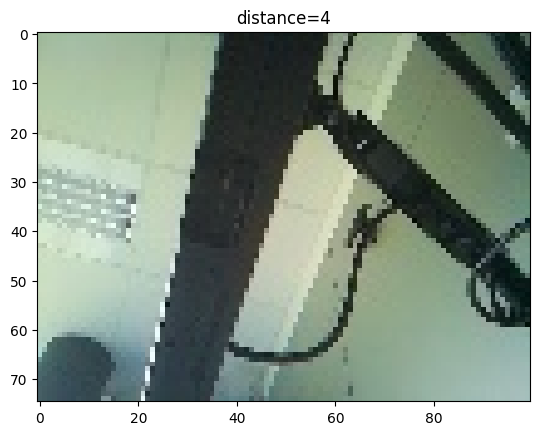

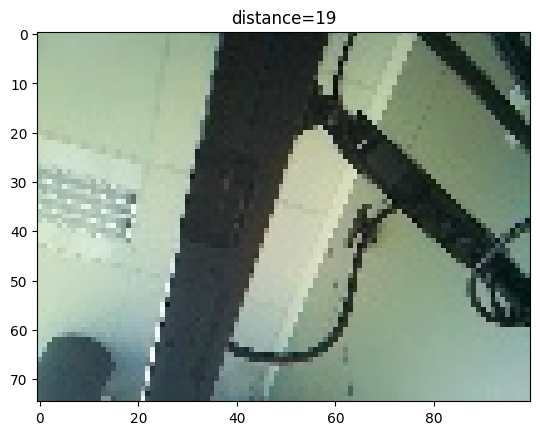

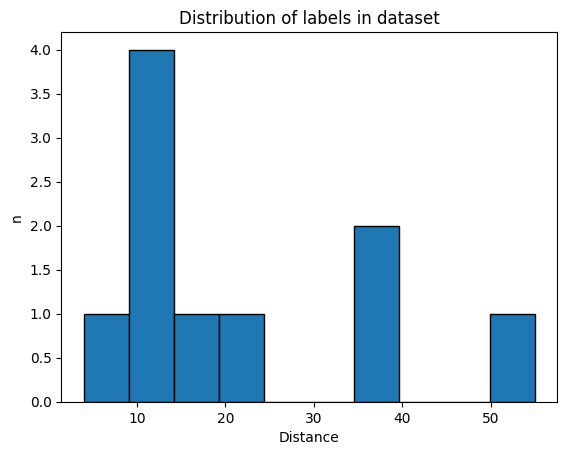

In [8]:
print("Number of position training images: ", images.shape[0])
print("Label von ", np.min(labels), " bis ", np.max(labels))

def plot_image(input_image, label):
  image = np.copy(input_image)
  image = image[:,:,::-1]
  plt.imshow(image)
  plt.title(f'distance={label[0]}')
  plt.show()

# Plot some images
num_images_to_plot = 2
for i in range(0, num_images_to_plot):
  plot_image(images[i], labels[i])

# Plot histogram of labels
plt.hist(labels, bins=10, edgecolor='black')  # Erstelle das Histogramm mit 10 Bins
plt.title('Distribution of labels in dataset')
plt.xlabel('Distance [mm]')
plt.ylabel('n')
plt.show()

### Preprocess dataset
The dataset is preprocessed using the submodule `model/preprocess_data.py`.

In [ ]:
from model.preprocess_data import preprocess_data

x_train, x_test = preprocess_data(x_train, x_test)

In [ ]:
# Training set:
# Calc mean and std of pixel values
print("\nTrainingsdaten: ")
mean = np.mean(x_train)
std = np.std(x_train)
max = np.max(x_train)
min = np.min(x_train)
print(f"Anzahl: {x_train.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_train.shape[1]} x {x_train.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_train))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Test set:
# Calc mean and std of pixel values
print("\nTestdaten: ")
mean = np.mean(x_test)
std = np.std(x_test)
max = np.max(x_test)
min = np.min(x_test)
print(f"Anzahl: {x_test.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {x_test.shape[1]} x {x_test.shape[2]}")
print(f"Anzahl der Klassen: {len(np.unique(y_test))}")

# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"{y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3: Model

### Create model
The model is created using `model/create_model.py`

In [ ]:
from model.create_model import create_model

model = create_model(dropout=0.2)

### Inspect model

In [ ]:
model.summary()

### Model training
The model is trained using `model_fit_model.py`
This should ideally be done using the workflow.

In [ ]:
from model.fit_model import fit_model

history = fit_model(model, x_train, y_train,
              optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              epochs=5)

In [ ]:
print(f"Final loss: {history.history['loss'][-1]:.4f}")
print(f"Final accuracy: {history.history['accuracy'][-1]:.4f}")

# Trainings- und Validierungsverlust
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per epoch')
plt.xlabel('Epopch')
plt.ylabel('Loss')
plt.legend()

# Genauigkeit (Accuracy) plotten
plt.figure(2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate model
The model is evaluated using `model/evaluate_model.py`

In [ ]:
from model.evaluate_model import evaluate_model

test_loss, test_acc = evaluate_model(model, x_test, y_test)

In [ ]:
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


### Save model

In [ ]:
model.save('model.keras')